In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import KFold

In [2]:
from mapie.classification import MapieClassifier
from mapie.metrics import (classification_coverage_score,
                           classification_mean_width_score)

This is a basic data set from an old Kaggle competition. There are 3 classes, galaxy/star/quasar, and the input features are some photometric bands. 

In [3]:
df = pd.read_csv('star_classification.csv')

In [4]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

We start by transforming the labels from string to integer:

In [5]:
LE = LabelEncoder()
df['class'] = LE.fit_transform(df['class'])
df['class'].value_counts()

class
0    59445
2    21594
1    18961
Name: count, dtype: int64

And we get rid of some columns to define our basic feature matrix/target vector (X and y):

In [6]:
X = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID', 'spec_obj_ID', 'MJD', 'class', 'plate'], axis = 1)
y = df['class']

In [7]:
X.head()

,u,g,r,i,z,redshift
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123


We will be using two models, a Gaussian Naive Bayes model (pretty poor) and a Random Forest Classifier (better) in order to show the differences when conformal predictions are used.

In [8]:
modelNB = GaussianNB()

In [9]:
pred = cross_val_predict(modelNB, X, y, cv = KFold(n_splits = 5, shuffle=True, random_state=10))

In [10]:
print(confusion_matrix(y, pred))  #Not too impressive

[[54366  4962   117]
 [ 2278 16682     1]
 [12857  2554  6183]]


In [11]:
print(classification_report(y, pred))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84     59445
           1       0.69      0.88      0.77     18961
           2       0.98      0.29      0.44     21594

    accuracy                           0.77    100000
   macro avg       0.82      0.69      0.69    100000
weighted avg       0.81      0.77      0.74    100000



In [12]:
#This takes a little longer to run

modelRF = RandomForestClassifier(random_state = 10, class_weight='balanced')

In [13]:
predb = cross_val_predict(modelRF, X, y, cv = KFold(n_splits = 5, shuffle=True, random_state=10))

In [14]:
print(confusion_matrix(y, predb)) # Much better results

[[58705   645    95]
 [ 1370 17588     3]
 [   13     0 21581]]


In [15]:
print(classification_report(y, predb)) 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     59445
           1       0.96      0.93      0.95     18961
           2       1.00      1.00      1.00     21594

    accuracy                           0.98    100000
   macro avg       0.98      0.97      0.98    100000
weighted avg       0.98      0.98      0.98    100000



### Conformal predictions

Let's now start with the conformal predictions part, beginning with the first model.

In [16]:
model = modelNB

We split the data in training and calibration sets (we should do train/calibration/validation, see below); this is to illustrate how it works.

In [17]:
X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=0.33, random_state=10)

In [18]:
model.fit(X_train, y_train)

GaussianNB()

In [19]:
n = len(y_calib) #we need a correction for finite set size

We start by generating probabilities from naive model

In [20]:
pred_calib = model.predict_proba(X_calib) 

In [21]:
pred_calib[0] # for the first element, these are probabilities associated to each class. 

array([7.33553785e-08, 9.99999927e-01, 0.00000000e+00])

Next, we define the probability associated to the true class for each object.

In [22]:
prob_true_class = pred_calib[np.arange(len(y_calib)),y_calib] 

In [23]:
prob_true_class

array([0.99999993, 0.98120114, 0.01146975, ..., 0.98667419, 0.99999583,
       0.9921384 ])

#### In the simplest formulation of CP, the non-conformity scores (low = good, high = bad) are defined as: 1 - prob_true_class:

In [24]:
cscores = 1 - prob_true_class

In [25]:
#Take a look

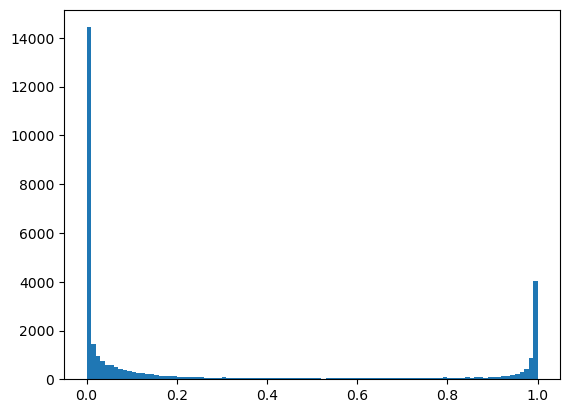

In [26]:
plt.hist(cscores, bins = 100);

On average, what is the 90% (or any other quantile) of the conformal scores? Setting 1- this as probability threshold that is included will guarantee that on average, the true value is within the set at least 90% of the time (*marginal* coverage guarantee).

In [27]:
alpha = 0.1

We can now find the quantile of conformal scores associated with that probability:

In [28]:
qhat = np.quantile(cscores, (1-alpha)*(n+1)/n)

In [29]:
qhat 

0.993543076537016

Because this model is not great, the quantile we need to reach is very high. Remember, we include any class that is predicted with at least 1 - qhat probability.

In [30]:
1 - qhat

0.006456923462983988

In [31]:
#These are the probs for the first 10 objects. Any time we find p > "value above", the class will be included in the set.

model.predict_proba(X_calib)[:10] 

array([[7.33553785e-008, 9.99999927e-001, 0.00000000e+000],
       [9.81201143e-001, 1.87988566e-002, 0.00000000e+000],
       [9.87988364e-001, 5.41888914e-004, 1.14697470e-002],
       [1.00000000e+000, 2.62292233e-010, 9.06898750e-141],
       [9.37226777e-008, 9.99999906e-001, 0.00000000e+000],
       [9.99973294e-001, 2.67062113e-005, 0.00000000e+000],
       [4.56367772e-003, 9.95436322e-001, 0.00000000e+000],
       [8.39620143e-001, 1.56044164e-001, 4.33569345e-003],
       [9.94538529e-001, 1.90240379e-003, 3.55906759e-003],
       [3.66459338e-001, 4.22342943e-012, 6.33540662e-001]])

#### Finally, we calculate prediction sets on calibration data:

In [32]:
prediction_sets = (model.predict_proba(X_calib) >= 1 - qhat) 

Let's compare the predictions for the first 10 objects with the original model and the new strategy:

In [33]:
y_calib_pred = model.predict(X_calib)

In [34]:
y_calib[:10] #True values, for reference

33226    1
64804    0
39763    2
51270    0
9698     1
5948     1
27955    1
55001    2
50875    2
47755    2
Name: class, dtype: int64

In [35]:
y_calib_pred[:10].reshape(-1,1) #Classes predicted by the NB model

array([[1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [2]])

Here are the prediction sets (original they are boolean variables so we re-cast them as integer):

In [36]:
prediction_sets[:10].astype(int) #For example, for object 2, two classes are included; for object 3, all classes

array([[0, 1, 0],
       [1, 1, 0],
       [1, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 1, 0],
       [1, 0, 0],
       [1, 0, 1]])

#### Let's now check our guaranteed marginal coverage.

In [37]:
prediction_sets[np.arange(len(y_calib)), y_calib] #This returns whether true label is in set

array([ True,  True,  True, ...,  True,  True,  True])

We can average this to get the empirical coverage:

In [38]:
empirical_coverage = prediction_sets[np.arange(len(y_calib)), y_calib].mean()

In [39]:
empirical_coverage 

0.9

Success! (empirical coverage matches request!)

Finally, we can calculate the average set size and the spread of set sizes - this is important, because (given same marginal coverage) better models will yield 1) smaller prediction sets; 2) higher spread in set size, which is evidence of adaptivity.

Note that this is less meaningful when there are few classes!


In [40]:
# Average set size 

prediction_sets.sum(axis=1).mean()

1.5833030303030302

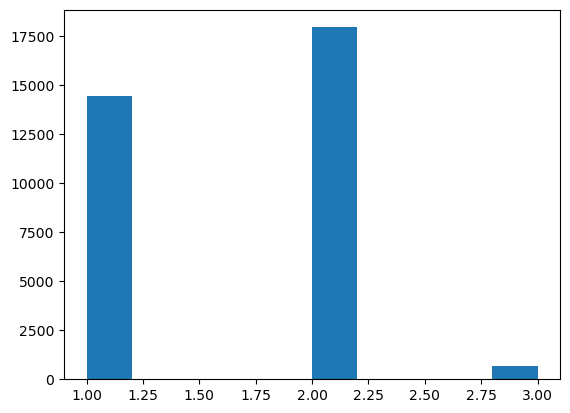

In [41]:
# Distribution of sizes

plt.hist(prediction_sets.sum(axis=1));

### What would happen when we use the better model (e.g., Random Forest?)

Expectations:
    
    Same marginal coverage
    
    Smaller prediction sets

In [42]:
model = RandomForestClassifier(random_state=10)

In [43]:
X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=0.33, random_state=10)

In [44]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

We start by generating new probabilities:

In [45]:
pred_calib = model.predict_proba(X_calib) 

Next, we define the probability associated to the true class for each object.

In [46]:
prob_true_class = pred_calib[np.arange(len(y_calib)),y_calib] 

In [47]:
prob_true_class

array([1.  , 0.97, 1.  , ..., 0.99, 1.  , 1.  ])

We can derive the non-conformity scores (low = good, high = bad), again defined as 1 - prob_true_class, and plot them.

In [48]:
cscores = 1 - prob_true_class

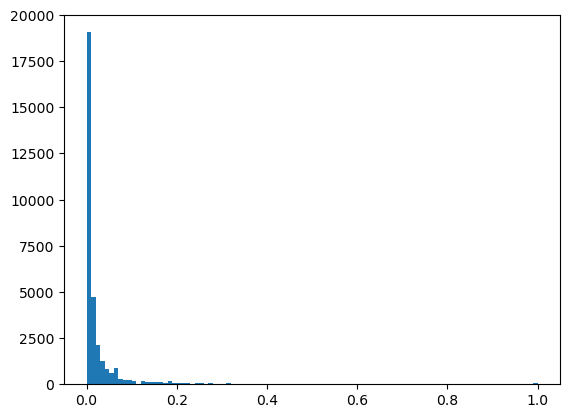

In [49]:
plt.hist(cscores, bins = 100);

As you can see, there are very few examples where the correct class is predicted with high probability (right side).

We can now find the quantile of conformal scores associated with probability 90% (alpha = 0.1):

In [50]:
qhat = np.quantile(cscores, (1-alpha)*(n+1)/n)

In [51]:
qhat 

0.07999999999999996

In [52]:
1 - qhat

0.92

This now means that only classes predicted with probability p > 0.92 will be included in prediction sets.

In [53]:
#These are the probs for the first 10 objects. Any time we find p > 0.92, the class will be included in the set.

model.predict_proba(X_calib)[:10] 

array([[0.  , 1.  , 0.  ],
       [0.97, 0.03, 0.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.98, 0.02, 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ]])

#### Here are the prediction sets for this model:

In [54]:
prediction_sets = (model.predict_proba(X_calib) >= 1 - qhat) 

In [55]:
prediction_sets[:10].astype(int) 

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

For the first 10 objects (above), sets only have one element, hinting to average smaller set size.

#### Let's now check our guaranteed marginal coverage.

In [56]:
empirical_coverage = prediction_sets[np.arange(len(y_calib)), y_calib].mean()

In [57]:
empirical_coverage 

0.903

This still holds, so that's good.

Some surprises can come from looking at the average set size:

In [58]:
prediction_sets.sum(axis=1).mean()

0.910060606060606

Here avg size < 1 (some prediction sets are null)! This is ok, and it just means that our threshold is so high that the probability of 0.92 is not reached by any class for some uncertain examples.

Finally, we can look at the size distribution and observe the difference with the previous model.

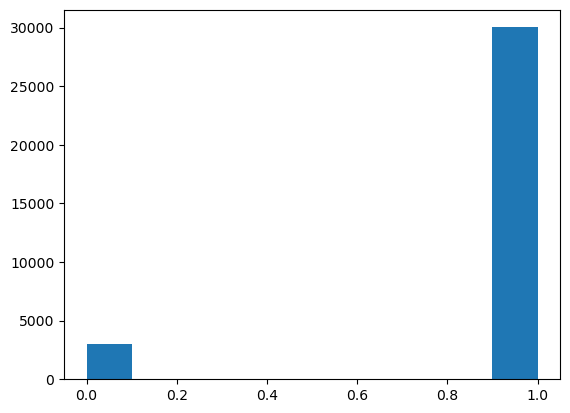

In [59]:
# Distribution of sizes

plt.hist(prediction_sets.sum(axis=1));

### Improvements:

- 3-way split (train to build model; calibration to find qhat; validation set to verify coverage and other properties).

- Adaptive sets and Regularized Adaptive Sets (APS and RAPS; see the introduction in [Angelopolous and Bates 2021](https://people.eecs.berkeley.edu/~angelopoulos/publications/downloads/gentle_intro_conformal_dfuq.pdf)

- Using the [MAPIE library](https://mapie.readthedocs.io/en/stable/) instead of writing code from scratch; derive diagnostics.

We will demonstrate all these with the Naive Bayes model.

### 3-way split

We can use the train_test_split function twice to get 3 splits, here: 2/3, 1/6, 1/6.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

X_calib, X_val, y_calib, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=10)

n = len(y_calib)

n_val = len(y_val)

#Train model

#model = RandomForestClassifier(random_state=10)

model = GaussianNB()

model.fit(X_train, y_train)

#Compute probability scores

pred_calib = model.predict_proba(X_calib) #predicted probabilities for cal set

pred_val = model.predict_proba(X_val) #predicted probabilities for val set

### Naive method - no adaptation

In [61]:
alpha = 0.1

In [62]:
# 1: get conformal scores on calibration set

cal_scores = 1 - pred_calib[np.arange(n), y_calib.values]

# 2: get adjusted quantile qhat

q_level = np.ceil((n+1)*(1-alpha))/n

qhat = np.quantile(cal_scores, q_level, method='higher')

# 3: form prediction sets on validation set; include all classes predicted with prob > 1 - qhat

prediction_sets = pred_val >= (1 - qhat) 

empirical_coverage = prediction_sets[np.arange(len(y_val)), y_val].mean()

print('Empirical marginal coverage on validation set:', np.round(empirical_coverage,3)) #should match 1 - alpha

print('Average set size:', np.round(prediction_sets.sum(axis=1).mean(),2) )

Empirical marginal coverage on validation set: 0.905
Average set size: 1.59


These are quite similar to those obtained on the calibration set - yay!

### Adaptive sets

Empirical coverage on validation set 0.9297575757575758
Average set size 2.2324848484848485


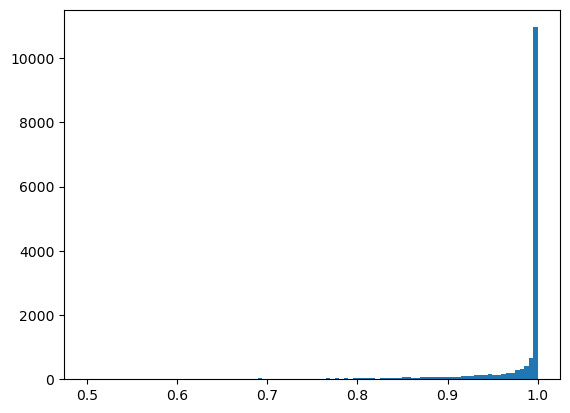

In [63]:
#Code adapted from Angelopolous and Bates; main idea here is to consider the scores cumulatively.

#Calibration set is used to find correct quantile qhat

cal_pi = pred_calib.argsort(1)[:, ::-1]
cal_srt = np.take_along_axis(pred_calib, cal_pi, axis=1).cumsum(axis=1)
cal_scores = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[range(n), y_calib]

plt.hist(cal_scores, bins = 100);

# Get the score quantile

qhat = np.quantile(cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, method="higher")

# Deploy on validation set

val_pi = pred_val.argsort(1)[:, ::-1]

val_srt = np.take_along_axis(pred_val, val_pi, axis=1).cumsum(axis=1)

adap_prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)

empirical_coverage = adap_prediction_sets[np.arange(len(y_val)), y_val].mean()

print('Empirical coverage on validation set', empirical_coverage)

print('Average set size', adap_prediction_sets.sum(axis=1).mean())

### RAPS (Regularized APS)

This doesn't work as well in the sense that the marginal coverage is off, and it doesn't match MAPIE, but I couldn't figure why, despite exploring the parameters as explained in the paper.

Empirical coverage on validation set 0.65
Average set size 1.58


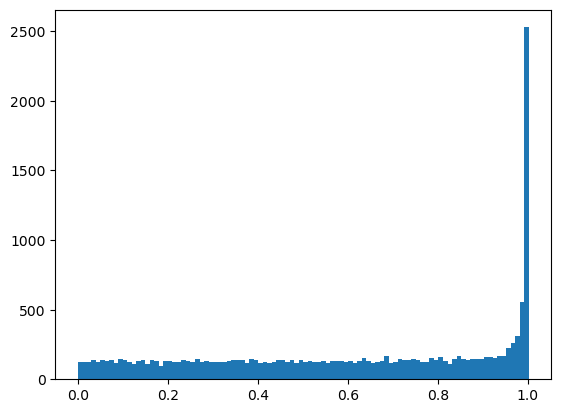

In [64]:
# Set RAPS regularization parameters (larger lam_reg and smaller k_reg leads to smaller sets)

lam_reg = 0.001 #from paper: lambda_ in [.001, .01, .1, .2, .5]

k_reg = 1 #This needs to be <= the total number of classes; 
        # it's the maximum size of set allowed for large lambda before incurring in a large penalty

disallow_zero_sets = False # Set this to False in order to see the coverage upper bound hold

rand = True # Set this to True in order to see the coverage upper bound hold

reg_vec = np.array(k_reg*[0,] + (pred_calib.shape[1]-k_reg)*[lam_reg,])[None,:]

# Get conformal scores on calibration set

cal_pi = pred_calib.argsort(1)[:,::-1]; 

cal_srt = np.take_along_axis(pred_calib,cal_pi,axis=1)

cal_srt_reg = cal_srt + reg_vec

cal_L = np.where(cal_pi == y_calib.values[:,None])[1]

cal_scores = cal_srt_reg.cumsum(axis=1)[np.arange(n),cal_L] - np.random.rand(n)*cal_srt_reg[np.arange(n),cal_L]

plt.hist(cal_scores, bins = 100);

# Get the score quantile

qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, method = 'lower')

# Deploy

val_srt_reg_cumsum = cal_srt_reg.cumsum(axis=1)

indicators = (cal_srt_reg.cumsum(axis=1) - np.random.rand(n,1)*cal_srt_reg) <= qhat if rand else cal_srt_reg.cumsum(axis=1) - cal_srt_reg <= qhat

if disallow_zero_sets: indicators[:,0] = True

raps_prediction_sets = np.take_along_axis(indicators,cal_pi.argsort(axis=1),axis=1)

empirical_coverage = raps_prediction_sets[np.arange(len(y_val)), y_val].mean()

print('Empirical coverage on validation set', np.round(empirical_coverage,2)) #This doesn't seem a great match

print('Average set size', np.round(raps_prediction_sets.sum(axis=1).mean(),2) )

Lingering question: Why is convergence so off with RAPS?

### MAPIE

Using MAPIE, we can implement the original (lac = Least Ambiguous set-valued Classifier) method, APS, and RAPS.

Results are in agreement with the typed code for lac and aps, seem off for RAPS; it might be a hyperparameter issue.

In [65]:
#Start by defining model

model = modelNB

alpha = 0.1

print('Desired coverage:', 1-alpha)

methods = ["lac", "aps", "raps"]

for method in methods:

    mapie_score = MapieClassifier(estimator=model, cv="prefit", method=method) # usage note: "score" and "lac" appear to be the same

    mapie_score.fit(X_calib, y_calib)

    #y_pred_score is the class predicted by the original model; y_ps_score is the prediction from MAPIE

    y_pred_score, y_ps_score = mapie_score.predict(X_val, alpha=alpha)
    
    print('For method:', method)
    print('Empirical coverage: ', np.round(y_ps_score.reshape(len(y_val),3)[np.arange(len(y_val)), y_val].mean(),3))
    print('Average set size', np.round(y_ps_score.reshape(len(y_val),3).sum(axis=1).mean(),3) )

Desired coverage: 0.9
For method: lac
Empirical coverage:  0.905
Average set size 1.588
For method: aps
Empirical coverage:  0.952
Average set size 1.678
For method: raps
Empirical coverage:  0.952
Average set size 1.679


As a diagnostic tool, we can also plot:

1) The quantile corresponding to a certain coverage (left, not very useful on its own);
2) The accuracy of effective coverage (wrt target) as f(alpha); this should be the x=y line, ideally;
3) The set sizes; for same marginal coverage, we generally prefer smaller sets.

Adapted from:

https://mapie.readthedocs.io/en/stable/examples_classification/1-quickstart/plot_comp_methods_on_2d_dataset.html#sphx-glr-examples-classification-1-quickstart-plot-comp-methods-on-2d-dataset-py

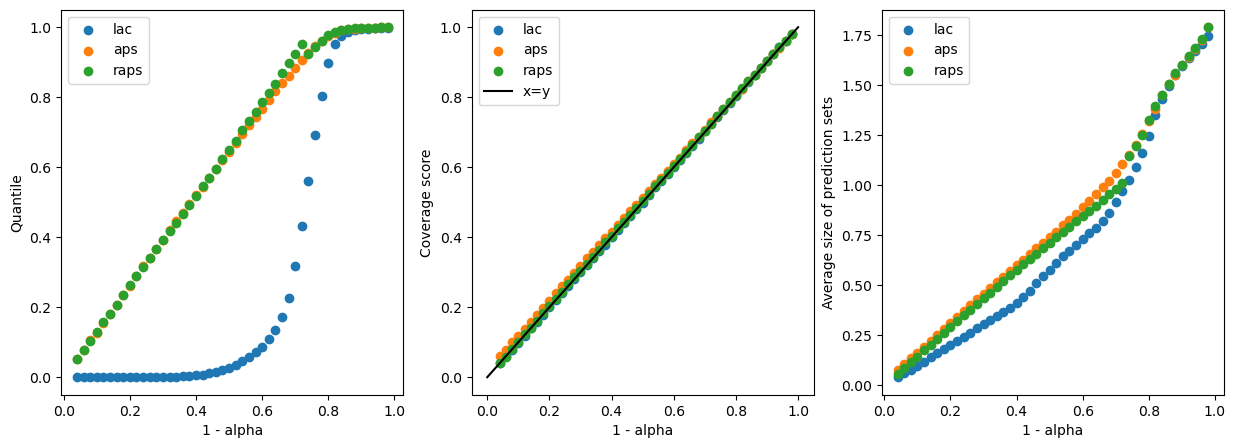

In [66]:
methods = ["lac", "aps", "raps"]
alpha_ = np.arange(0.02, 0.98, 0.02)
coverage, mean_width = {}, {}
mapie, y_ps_mapie = {}, {}
for method in methods:
    mapie[method] = MapieClassifier(
        estimator=modelNB,
        method=method,
        cv="prefit",
        random_state=42,
    )
    mapie[method].fit(X_calib, y_calib.values)
    _, y_ps_mapie[method] = mapie[method].predict(
        X, alpha=alpha_, include_last_label="randomized"
    )
    coverage[method] = [
        classification_coverage_score(y, y_ps_mapie[method][:, :, i])
        for i, _ in enumerate(alpha_)
    ]
    mean_width[method] = [
        classification_mean_width_score(y_ps_mapie[method][:, :, i])
        for i, _ in enumerate(alpha_)
    ]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_xlabel("1 - alpha")
axs[0].set_ylabel("Quantile")
for method in methods:
    axs[0].scatter(1 - alpha_, mapie[method].quantiles_, label=method)
axs[0].legend()
for method in methods:
    axs[1].scatter(1 - alpha_, coverage[method], label=method)
axs[1].set_xlabel("1 - alpha")
axs[1].set_ylabel("Coverage score")
axs[1].plot([0, 1], [0, 1], label="x=y", color="black")
axs[1].legend()
for method in methods:
    axs[2].scatter(1 - alpha_, mean_width[method], label=method)
axs[2].set_xlabel("1 - alpha")
axs[2].set_ylabel("Average size of prediction sets")
axs[2].legend()
plt.show()




### What happens for Random Forest model?

This shows the inconsistencies found for the RF model. Still can't explain them.

Empirically, I saw that there are problems (e.g. marginal coverage doesn't hold well) for the "good" RF model for adaptive sets (the simplest method still works). I am not sure of what the reason is; it may have to do with having only 3 classes, so variability in sets is limited.

In [67]:
model = RandomForestClassifier(random_state=10)

In [68]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

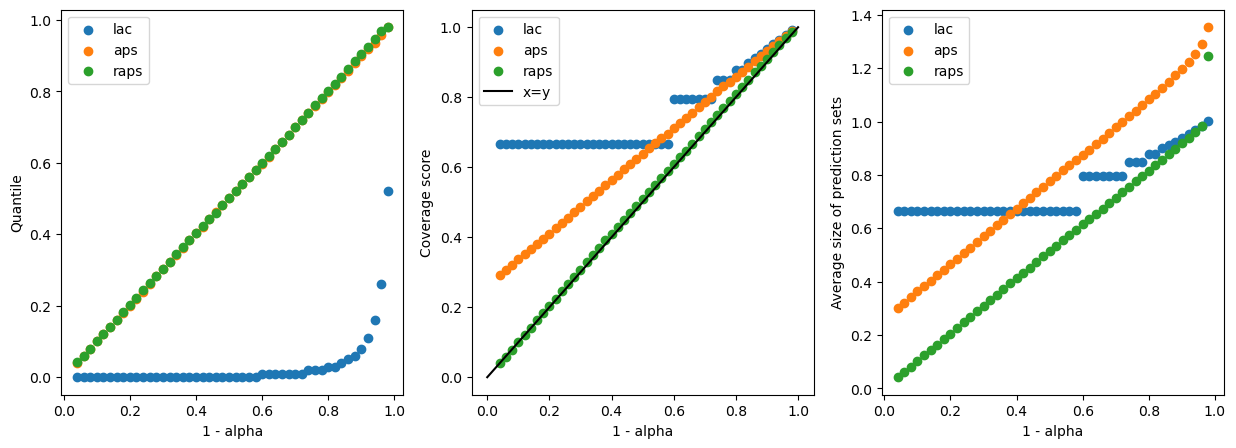

In [69]:
methods = ["lac", "aps", "raps"]
alpha_ = np.arange(0.02, 0.98, 0.02)
coverage, mean_width = {}, {}
mapie, y_ps_mapie = {}, {}
for method in methods:
    mapie[method] = MapieClassifier(
        estimator=model,
        method=method,
        cv="prefit",
        random_state=42,
    )
    mapie[method].fit(X_calib, y_calib.values)
    _, y_ps_mapie[method] = mapie[method].predict(
        X, alpha=alpha_, include_last_label="randomized"
    )
    coverage[method] = [
        classification_coverage_score(y, y_ps_mapie[method][:, :, i])
        for i, _ in enumerate(alpha_)
    ]
    mean_width[method] = [
        classification_mean_width_score(y_ps_mapie[method][:, :, i])
        for i, _ in enumerate(alpha_)
    ]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_xlabel("1 - alpha")
axs[0].set_ylabel("Quantile")
for method in methods:
    axs[0].scatter(1 - alpha_, mapie[method].quantiles_, label=method)
axs[0].legend()
for method in methods:
    axs[1].scatter(1 - alpha_, coverage[method], label=method)
axs[1].set_xlabel("1 - alpha")
axs[1].set_ylabel("Coverage score")
axs[1].plot([0, 1], [0, 1], label="x=y", color="black")
axs[1].legend()
for method in methods:
    axs[2].scatter(1 - alpha_, mean_width[method], label=method)
axs[2].set_xlabel("1 - alpha")
axs[2].set_ylabel("Average size of prediction sets")
axs[2].legend()
plt.show()
